In [1]:
import numpy as np
from matplotlib import pyplot as plt

import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Conv2D, AveragePooling2D, MaxPool2D, Flatten, Activation, concatenate, Dropout
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization as BN
%matplotlib inline

Using TensorFlow backend.


In [2]:
def show_data(data, label, rows=2, cols=5):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    for idx in range(1, (rows*cols)+1):
        plt.subplot(rows, cols, idx)
        plt.imshow(data[idx-1])
        plt.title("Lable=%s"%label[idx-1])

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

(32, 32, 3)


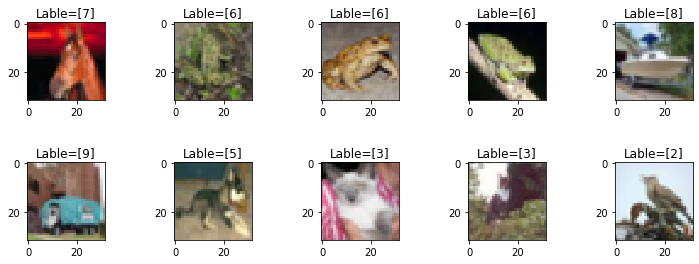

In [4]:
idx = np.random.randint(0, x_train.shape[0], (10,))
show_data(x_train[idx], y_train[idx])
print(x_train[0].shape)

In [5]:
# 將y 轉換為One hot encoding
fit_y_train = np_utils.to_categorical(y_train)
pred_y_test = np_utils.to_categorical(y_test)

# Build Model
### AlexNet: 
* 5層 convolution layer, 3層 Dense layer
* 用 ReLu 當作 activation function
    * 收斂速度快，計算少，避免gradient vanishing
* 用 Data augmentation 和 Dropout 來防止 Overfitting
    * 沒有實做原版data augmentation 的部份
    * 1. Reflection & Extracting: 原圖256*256 + 水平鏡射，各切出1024張 224*224，共2048。
    * 2. PCA:對 RGB 空間做PCA，加入高斯隨機擾動。這個方法是透過自然圖片的性質來實現，也就是該物體對於照明的強度和顏色的變化是不變的。
* Local Response Normalization, 接在ReLu後
    * 後續研究發現效果不大，大多改用Batch Normalization
* 用 max pooling
    * LeNet是用average pooling但會有特徵被模糊化的問題
* Overlapping Pooling 降低錯誤率，對防止Overfitting 也有幫助
    * 使Pooling層重疊，可以降低原始特徵在深層Convolution的損失，所以錯誤率會下降。
    * 之後的研究普遍認為Overlapping Pooling效果不會比沒重疊的pooling更好
* 多個GPU並行運算 (這次沒實做)
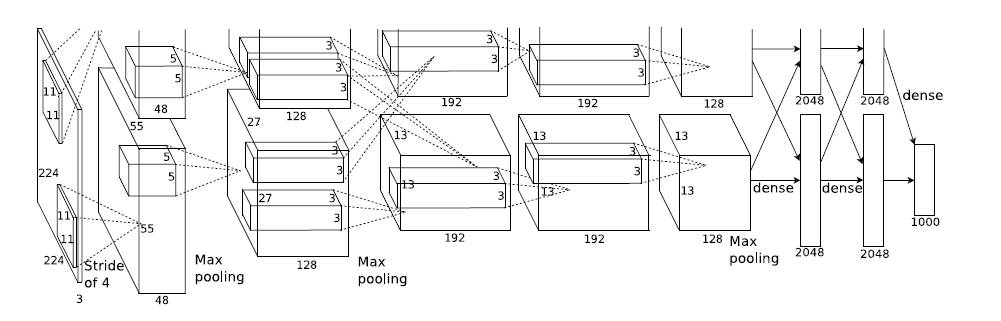

In [12]:
def AlexNet(width, height, depth):
    input_layer = Input(shape=(32,32,3))
    conv1 = Conv2D(filters=6, kernel_size=(5,5))(input_layer)
    bn_layer_1 = BN()(conv1)
    conv1_activate = Activation('relu')(bn_layer_1)
    cpool1 = MaxPool2D()(conv1_activate)
   
    conv2 = Conv2D(filters=16, kernel_size=(3,3))(cpool1)
    bn_layer_2 = BN()(conv2)
    conv2_activate = Activation('relu')(bn_layer_2)
    cpool2 = MaxPool2D()(conv2_activate)
    
    conv3 = Conv2D(filters=19, kernel_size=(3,3))(cpool2)
    bn_layer_3 = BN()(conv3)
    conv3_activate = Activation('relu')(bn_layer_3)
#    cpool3 = MaxPool2D()(conv3_activate)
    
    conv4 = Conv2D(filters=19, kernel_size=(3,3))(conv3_activate)
    bn_layer_4 = BN()(conv4)
    conv4_activate = Activation('relu')(bn_layer_4)
#    cpool4 = MaxPool2D()(conv4_activate)
    
    
#     flat_v = Flatten()(cpool2)
    flat_v = Flatten()(conv4_activate)
    dense1 = Dense(120, activation='relu')(flat_v)
    bn_layer_den1 = BN()(dense1)
    dropout1 = Dropout(0.5)(bn_layer_den1)
    
    dense2 = Dense(82, activation='relu')(bn_layer_den1)
    bn_layer_den2 = BN()(dense2)
    dropout2 = Dropout(0.5)(bn_layer_den2)
    
    output_layer = Dense(10, activation='softmax')(bn_layer_den2)
    model = Model(input_layer, output_layer)
    
    return model

In [13]:
AlexNet_Model = AlexNet(32, 32, 3)
AlexNet_Model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
AlexNet_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 6)         24        
_________________________________________________________________
activation_13 (Activation)   (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 12, 16)        880       
_________________________________________________________________
batch_normalization_16 (Batc (None, 12, 12, 16)        64        
__________

In [ ]:
history = AlexNet_Model.fit(x=x_train, y=fit_y_train, validation_data=[x_test, pred_y_test], epochs=30, batch_size=64)

W0911 01:04:44.917738 140290614830912 deprecation.py:323] From /home/tsung/miniconda3/envs/myenv/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 11s 224us/step - loss: 1.7391 - acc: 0.3691 - val_loss: 1.5163 - val_acc: 0.4420
Epoch 2/30
50000/50000 [==============================] - 7s 150us/step - loss: 1.4098 - acc: 0.4912 - val_loss: 1.6366 - val_acc: 0.4156
Epoch 3/30
50000/50000 [==============================] - 8s 151us/step - loss: 1.2810 - acc: 0.5419 - val_loss: 1.4096 - val_acc: 0.5007
Epoch 4/30
50000/50000 [==============================] - 8s 154us/step - loss: 1.2018 - acc: 0.5719 - val_loss: 1.2228 - val_acc: 0.5607
Epoch 5/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.1437 - acc: 0.5931 - val_loss: 1.6283 - val_acc: 0.4643
Epoch 6/30
50000/50000 [==============================] - 8s 155us/step - loss: 1.0996 - acc: 0.6108 - val_loss: 1.1455 - val_acc: 0.5887
Epoch 7/30
50000/50000 [==============================] - 8s 162us/step - loss: 1.0663 - acc: 0.6227 - val_loss: 1.2565 -

In [13]:
datagen = ImageDataGenerator(rotation_range=15,    
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,)
datagen.fit(x_train)


In [14]:
dg_bn_training_history = AlexNet_Model.fit_generator(datagen.flow(x_train, fit_y_train, batch_size=64),
                                                steps_per_epoch=x_train.shape[0]//64,
                                                epochs=30,
                                                validation_data=(x_test, pred_y_test))

Epoch 1/30
781/781 [==============================] - 21s 27ms/step - loss: 1.1303 - acc: 0.6087 - val_loss: 1.3804 - val_acc: 0.5555
Epoch 2/30
781/781 [==============================] - 20s 26ms/step - loss: 1.0674 - acc: 0.6232 - val_loss: 1.0915 - val_acc: 0.6151
Epoch 3/30
781/781 [==============================] - 20s 26ms/step - loss: 1.0524 - acc: 0.6279 - val_loss: 1.0166 - val_acc: 0.6402
Epoch 4/30
781/781 [==============================] - 21s 26ms/step - loss: 1.0397 - acc: 0.6314 - val_loss: 1.0723 - val_acc: 0.6304
Epoch 5/30
781/781 [==============================] - 22s 28ms/step - loss: 1.0213 - acc: 0.6383 - val_loss: 1.4190 - val_acc: 0.5453
Epoch 6/30
781/781 [==============================] - 20s 26ms/step - loss: 1.0173 - acc: 0.6406 - val_loss: 1.3113 - val_acc: 0.5623
Epoch 7/30
781/781 [==============================] - 22s 28ms/step - loss: 1.0134 - acc: 0.6419 - val_loss: 1.1434 - val_acc: 0.6033
Epoch 8/30
781/781 [==============================] - 23s 29ms

In [ ]:
# 2 CNN kernel size (5*5)&(3*3)， 3 DNN
# Epoch 30/30
# 50000/50000 [==============================] - 5s 95us/step - loss: 0.2765 - acc: 0.9012 - val_loss: 2.8119 - val_acc: 0.5434

# dropout
# Epoch 30/30
# 50000/50000 [==============================] - 5s 105us/step - loss: 1.1552 - acc: 0.5949 - val_loss: 1.1832 - val_acc: 0.5858

# BN
# Epoch 30/30
# 50000/50000 [==============================] - 9s 171us/step - loss: 0.3865 - acc: 0.8603 - val_loss: 1.6232 - val_acc: 0.6073

# BN + Generator
# Epoch 30/30
# 781/781 [==============================] - 19s 24ms/step - loss: 0.9063 - acc: 0.6766 - val_loss: 1.0477 - val_acc: 0.6449

# dropout + BN
# Epoch 30/30
# 50000/50000 [==============================] - 8s 153us/step - loss: 0.4088 - acc: 0.8536 - val_loss: 1.4137 - val_acc: 0.6234

# Dropout + BN + Generator
# Epoch 30/30
# 781/781 [==============================] - 21s 27ms/step - loss: 0.8573 - acc: 0.6999 - val_loss: 0.8183 - val_acc: 0.7098

# 3 層 conv

# 第一層改用3*3 kernel size, 差不多在15epoch就以收斂 
# Epoch 30/30
# 781/781 [==============================] - 21s 28ms/step - loss: 0.9084 - acc: 0.6780 - val_loss: 1.0114 - val_acc: 0.6541